### Laboratory work 12
### Vehicle tracking based on GPS andodometry data fusion
#### The objective of this laboratory work is to develop a tracking filterto estimate a vehicle’s dynamic  state  by  assimilating  the navigation  data  coming  from  different  sources.  The  task includes  the fusion  of GPS  data(absolute  positioning) andwheelodometry  data  (relative positioning).Important  outcome  of  this  exerciseis  getting  skill  tosolve the  most  fundamental data fusion tasks for intelligent traffic applications.

#### Abramov Semen, Belikov Ilia, Nikolay Zherdev, Mikhail Kulbeda
#### Skoltech, 24.10.2018

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
theta = np.loadtxt('/Users/sabramov/Downloads/theta.txt')

In [11]:
def generate_trajectory(x0, y0, V0, theta, N = 500, T = 0.5, sigma_acc = 1):
    ax = np.random.normal(0, sigma_acc, N)
    ay = np.random.normal(0, sigma_acc, N)
    Vx = np.zeros(N)
    V = np.zeros(N)
    Vy = np.zeros(N)
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = x0
    y[0] = y0
    Vx[0] = V0 * np.cos(theta[0])
    Vy[0] = V0 * np.cos(theta[0])
    V[0] = V0
    for i in range(1,N):
        Vx[i] = V[i-1] * np.cos(theta[i-1])
        Vy[i] = V[i-1] * np.sin(theta[i-1])
        V[i] = V0
        x[i] = x[i-1] + Vx[i-1]*T + ax[i-1]*T**2/2
        y[i] = y[i-1] + Vy[i-1]*T + ay[i-1]*T**2/2
    return [x,y]

In [12]:
def measure(x, y, N, sigma_nx, sigma_ny, mean = 0):
    msr_x = x + np.random.normal(loc = 0, scale = sigma_nx, size = N)
    msr_y = y + np.random.normal(loc = 0, scale = sigma_ny, size = N)
    return [msr_x, msr_y]

### Part 1
#### Assimilation of GPS data only (absolute positioning)

In [13]:
[x,y] = generate_trajectory(x0 = 0, y0 = 0, V0 = 10, theta = theta, N = 500, T = 0.5, sigma_acc = 1)

In [14]:
N = 500
T = 0.5
time = T * np.array(range(N))

In [15]:
[msr_x, msr_y] = measure(x, y, N = 500, sigma_nx = 3, sigma_ny = 3)

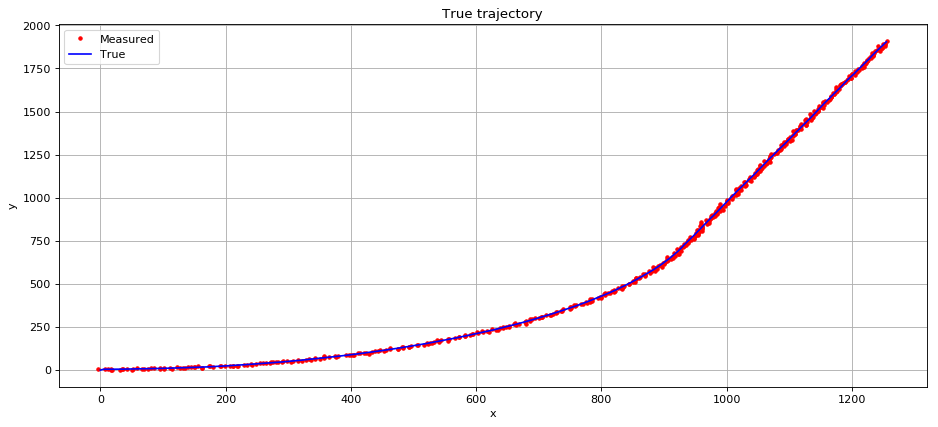

In [16]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(msr_x, msr_y, "r.", label='Measured')
plt.plot(x, y, "b-", label='True')
plt.title('True trajectory')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

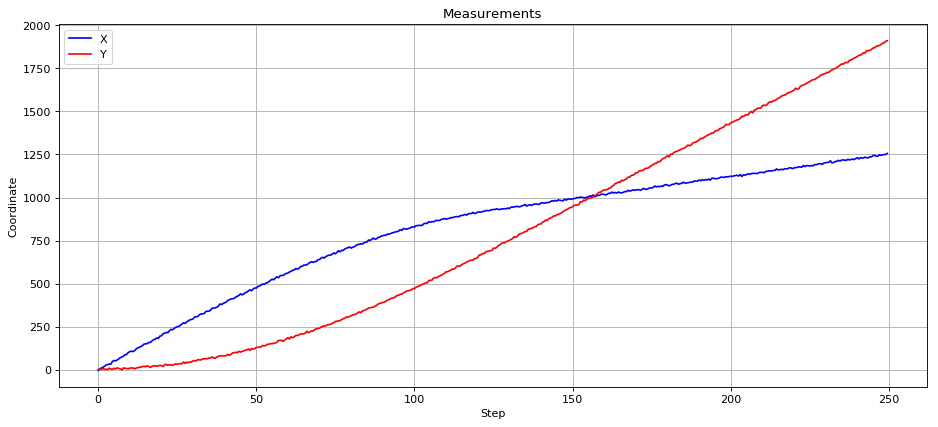

In [46]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, msr_x, "b-", label='X')
plt.plot(time, msr_y, "r-", label='Y')
plt.title('Measurements')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

In [18]:
F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
G = np.array([[T**2/2, 0], [T, 0], [0, T**2/2], [0, T]])

####  We should increase the covariance matrix of state noise, that will result in a greater filter gain K, and thus more confidence to measurements. In other words, by increasing variance of random acceleration we compensate the imperfections of the motion model.

In [ ]:
 we should increase the covariance matrix of state noise, that will result in a greater filter gain 퐾, and thus more confidence to measurements. In other words, by increasing 휎푎2we compensate the imperfections of the motion model.

In [19]:
sigma_a_new = 5
Q = np.dot(G, G.T) * sigma_a_new**2

In [20]:
def kalman(msr_x, msr_y, S0, P0, T, R, F, Q, H):
    N = msr_x.size
    z = np.array([msr_x, msr_y])
    Xp = np.zeros((4,N))
    Xp[:,0] = S0[:,0]
    Xf = np.zeros((4,N))
    Xf[:,0] = S0[:,0]
    Ht = H.T
    Ft = F.T
    I = np.eye(4)
    K = np.zeros((4,2,N))
    Pp = np.zeros((4,4,N))
    Pp[:,:,0] = P0
    Pf = np.zeros((4,4,N))
    Pf[:,:,0] = P0
    for i in range(1, N):
        # prediction
        Xp[:,i] = np.matmul(F, Xf[:,i-1])
        Pp[:,:,i] = np.matmul(np.matmul(F, Pf[:,:,i-1]), Ft) + Q
        # filtration
        K[:,:,i] = np.matmul(Pp[:,:,i], np.matmul(Ht, np.linalg.inv(np.matmul(np.matmul(H, Pp[:,:,i]), Ht) + R)))
        Xf[:,i] = Xp[:,i] + np.matmul(K[:,:,i], (z[:,i] - np.matmul(H, Xp[:,i])))
        Pf[:,:,i] = np.matmul(I - np.matmul(K[:,:,i], H), Pp[:,:,i])
    return [Xf, Xp, Pf, Pp];

In [21]:
sigma_nx = 3
sigma_ny = 3

S0 = np.array([[msr_x[1]], [(msr_x[1]-msr_x[0])/T], [msr_y[1]], [(msr_y[1]-msr_y[0])/T]])
P0 = np.eye(4) * 10**4;
R = np.array([[sigma_nx**2, 0], [0, sigma_ny**2]])
H = np.array([[1,0,0,0],[0,0,1,0]])

In [22]:
[Xf, Xp, Pf, Pp] = kalman(msr_x = msr_x, msr_y = msr_y, S0 = S0, P0 = P0, T = 0.5, R = R, F = F, Q = Q, H = H)

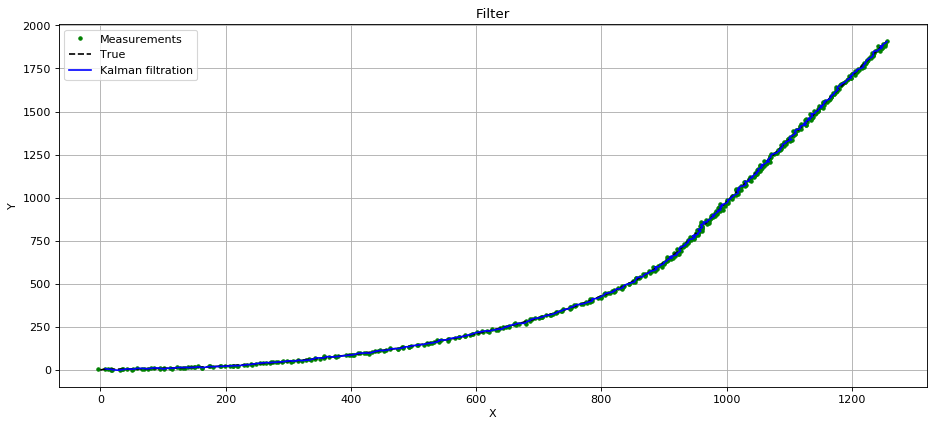

In [23]:
# Plot Kalman
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(msr_x, msr_y, "g.", label='Measurements')
plt.plot(x, y, "k--", label='True')
plt.plot(Xf[0], Xf[2], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

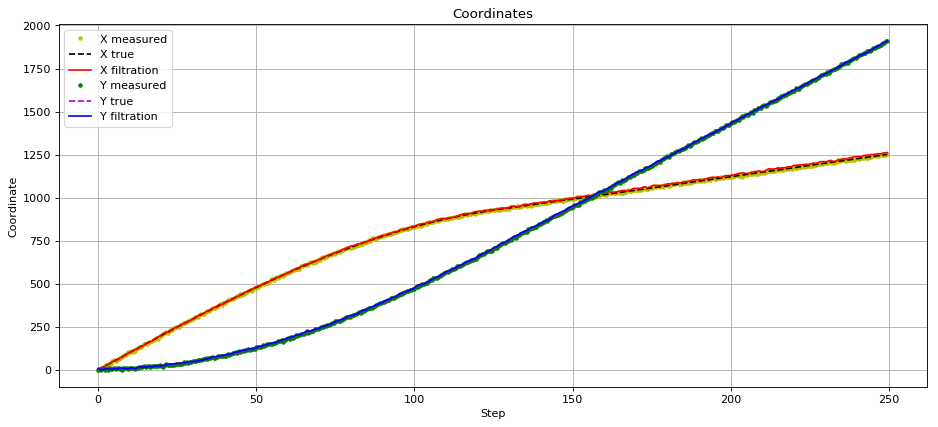

In [47]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, msr_x, "y.", label='X measured')
plt.plot(time, x, "k--", label='X true')
plt.plot(time, Xf[0], 'r-', label = "X filtration")
plt.plot(time, msr_y, "g.", label='Y measured')
plt.plot(time, y, "m--", label='Y true')
plt.plot(time, Xf[2], 'b-', label = "Y filtration")
plt.title('Coordinates')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

In [25]:
# errors of estimation
def errors_run(t, v):
    return (t - v) ** 2

In [26]:
# M runs
M = 500
ErrorRunXf = []
ErrorRunXp = []
ErrorRunYf = []
ErrorRunYp = []
for i in range(M):
    [x,y] = generate_trajectory(x0 = 0, y0 = 0, V0 = 10, theta = theta, N = 500, T = 0.5, sigma_acc = 1)
    [msr_x, msr_y] = measure(x, y, N = 500, sigma_nx = 3, sigma_ny = 3)
    [Xf, Xp, Pf, Pp] = kalman(msr_x = msr_x, msr_y = msr_y, S0 = S0, P0 = P0, T = 0.5, R = R, F = F, Q = Q, H = H)
    ErrorRunXf.append(errors_run(x, Xf[0]))
    ErrorRunXp.append(errors_run(x, Xp[0]))
    ErrorRunYf.append(errors_run(y, Xf[2]))
    ErrorRunYp.append(errors_run(y, Xp[2]))

In [27]:
Final_Error_Xf = (np.sum(ErrorRunXf, axis=0) / (M - 1)) ** .5
Final_Error_Xp = (np.sum(ErrorRunXp, axis=0) / (M - 1)) ** .5
Final_Error_Yf = (np.sum(ErrorRunYf, axis=0) / (M - 1)) ** .5
Final_Error_Yp = (np.sum(ErrorRunYp, axis=0) / (M - 1)) ** .5

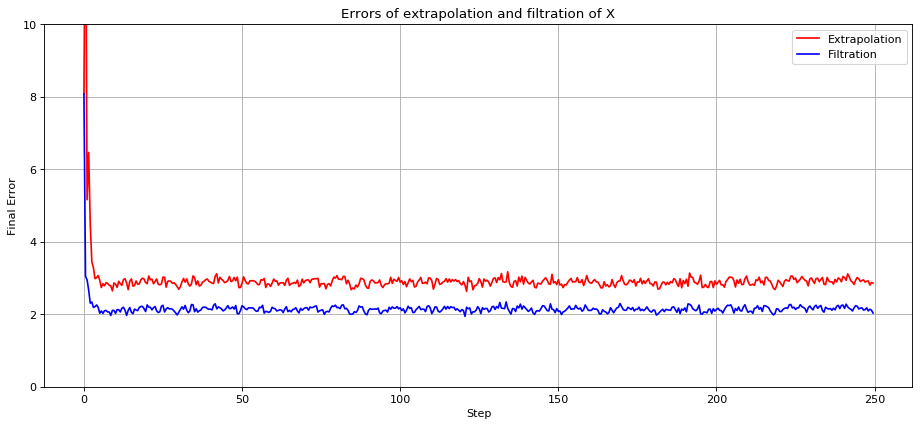

In [48]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Xp, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Xf, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of X')
plt.xlabel('Step')
plt.ylabel('Final Error')
plt.ylim(0,10)
plt.show()

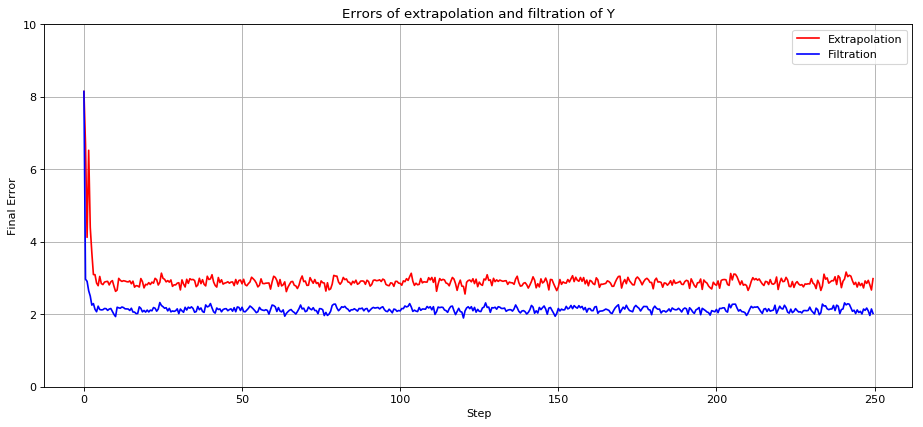

In [49]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Yp, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Yf, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of Y')
plt.xlabel('Step')
plt.ylabel('Final Error')
plt.ylim(0,10)
plt.show()

### Part 2

#### Assimilation of both GPS data (absolute positioning) and wheel odometry data (relative positioning).

In [30]:
[x,y] = generate_trajectory(x0 = 0, y0 = 0, V0 = 10, theta = theta, N = 500, T = 0.5, sigma_acc = 1)
[msr_x, msr_y] = measure(x, y, N = 500, sigma_nx = 3, sigma_ny = 3)

In [31]:
def measure_V(N, V, sigma_nV):
    return (V*np.ones(N) + np.random.normal(loc = 0, scale = sigma_nV, size = N))

def measure_theta(theta, sigma_ntheta):
    return (theta + np.random.normal(loc = 0, scale = sigma_ntheta, size= theta.size))

In [32]:
sigma_nV = .5

In [33]:
Vm = measure_V(N = 500, V = 10, sigma_nV = sigma_nV)

In [34]:
sigma_ntheta = .02

In [35]:
theta_m = measure_theta(theta = theta, sigma_ntheta = sigma_ntheta)

In [36]:
R = np.diag([sigma_nx**2,sigma_ny**2,sigma_nV**2,sigma_ntheta**2])

In [37]:
X0 = np.array([[msr_x[1]], [(msr_x[1]-msr_x[0])/T], [msr_y[1]], [(msr_y[1]-msr_y[0])/T]])

In [38]:
def _arctan(Vx,Vy):
    if Vx>0:
        return np.arctan(Vy/Vx)
    if Vy>=0 and Vx<0:
        return np.arctan(Vy/Vx)+np.pi
    if Vy<0 and Vx<0:
        return np.arctan(Vy/Vx)-np.pi
    # Vx == 0
    if Vy>0:
        return np.pi/2
    return -np.pi/2

def h(X):
    x = X[0]
    Vx = X[1]
    y = X[2]
    Vy = X[3]
    return np.array([[x],[y],[(Vx**2+Vy**2)**.5], [_arctan(Vx,Vy)]])

def dh_d(X):
    Vx = X[1]
    Vy = X[3]
    VV = Vx**2+Vy**2
    V = VV**.5
    return np.array([[1,0,0,0],[0,0,1,0],[0,Vx/V,0,Vy/V],[0,-Vy/VV,0,Vx/VV]])

def extended_kalman(msr_x, msr_y, Vm, theta_m, S0, P0, R, F, Q):
    N = msr_x.size
    z = np.array([msr_x, msr_y, Vm, theta_m])
    Xp = np.zeros((4,N))
    Xp[:,0] = S0[:,0]
    Xf = np.zeros((4,N))
    Xf[:,0] = S0[:,0]
    Ht = H.T
    Ft = F.T
    I = np.eye(4)
    K = np.zeros((4,4,N))
    Pp = np.zeros((4,4,N))
    Pp[:,:,0] = P0
    Pf = np.zeros((4,4,N))
    Pf[:,:,0] = P0
    for i in range(0,N-1):
        # prediction
        Xp[:,i+1] = np.matmul(F, Xf[:,i])
        Pp[:,:,i+1] = np.matmul(np.matmul(F, Pf[:,:,i]), Ft) + Q
        # filtration
        dhX_dX = dh_d(Xp[:,i+1])
        dhX_dX_T = np.transpose(dhX_dX)
        K[:,:,i+1] = np.matmul(Pp[:,:,i+1], np.matmul(dhX_dX_T, np.linalg.inv(np.matmul(np.matmul(dhX_dX, Pp[:,:,i+1]), dhX_dX_T) + R)))
        Xf[:,[i+1]] = Xp[:,[i+1]] + np.matmul(K[:,:,i+1], (z[:,[i+1]] - h(Xp[:,i+1])))
        Pf[:,:,i+1] = np.matmul(I - np.matmul(K[:,:,i+1], dhX_dX), Pp[:,:,i+1])
    return [Xf, Xp, Pf, Pp];

In [39]:
[x,y] = generate_trajectory(x0 = 0, y0 = 0, V0 = 10, theta = theta, N = 500, T = 0.5, sigma_acc = 1)
[msr_x, msr_y] = measure(x, y, N = 500, sigma_nx = 3, sigma_ny = 3)
X0 = np.array([[msr_x[1]], [(msr_x[1]-msr_x[0])/T], [msr_y[1]], [(msr_y[1]-msr_y[0])/T]])
[Xf2, Xp2, Pf2, Pp2] = extended_kalman(msr_x, msr_y, Vm, theta_m, S0, P0, R, F, Q)

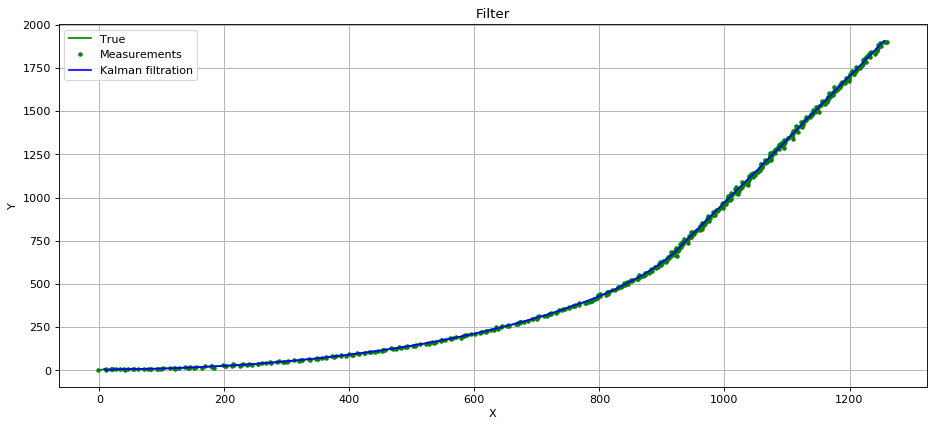

In [40]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, "g-", label='True')
plt.plot(msr_x, msr_y, "g.", label='Measurements')
plt.plot(Xf2[0], Xf2[2], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

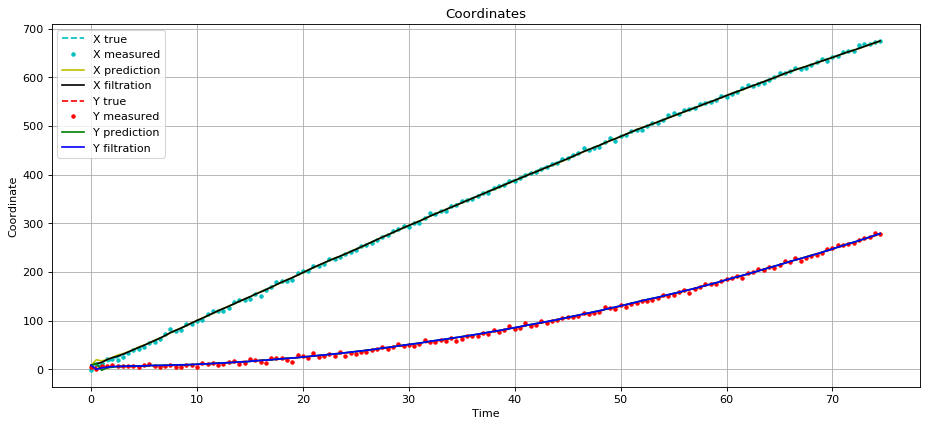

In [41]:
l = 150
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time[:l], x[:l], "c--", label='X true')
plt.plot(time[:l], msr_x[:l], "c.", label='X measured')
plt.plot(time[:l], Xp2[0][:l], 'y-', label = "X prediction")
plt.plot(time[:l], Xf2[0][:l], 'k-', label = "X filtration")
plt.plot(time[:l], y[:l], "r--", label='Y true')
plt.plot(time[:l], msr_y[:l], "r.", label='Y measured')
plt.plot(time[:l], Xp2[2][:l], 'g-', label = "Y prediction")
plt.plot(time[:l], Xf2[2][:l], 'b-', label = "Y filtration")
plt.title('Coordinates')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

In [42]:
# M runs
M = 500
ErrorRunXf2 = []
ErrorRunXp2 = []
ErrorRunYf2 = []
ErrorRunYp2 = []
for i in range(M):
    [x,y] = generate_trajectory(x0 = 0, y0 = 0, V0 = 10, theta = theta, N = 500, T = 0.5, sigma_acc = 1)
    [msr_x, msr_y] = measure(x, y, N = 500, sigma_nx = 3, sigma_ny = 3)
    S0 = np.array([[msr_x[1]], [(msr_x[1]-msr_x[0])/T], [msr_y[1]], [(msr_y[1]-msr_y[0])/T]])
    [Xf2, Xp2, Pf2, Pp2] = extended_kalman(msr_x, msr_y, Vm, theta_m, S0, P0, R, F, Q)
    ErrorRunXf2.append(errors_run(x, Xf2[0]))
    ErrorRunXp2.append(errors_run(x, Xp2[0]))
    ErrorRunYf2.append(errors_run(y, Xf2[2]))
    ErrorRunYp2.append(errors_run(y, Xp2[2]))

In [43]:
Final_Error_Xf2 = (np.sum(ErrorRunXf2, axis=0) / (M - 1)) ** .5
Final_Error_Xp2 = (np.sum(ErrorRunXp2, axis=0) / (M - 1)) ** .5
Final_Error_Yf2 = (np.sum(ErrorRunYf2, axis=0) / (M - 1)) ** .5
Final_Error_Yp2 = (np.sum(ErrorRunYp2, axis=0) / (M - 1)) ** .5

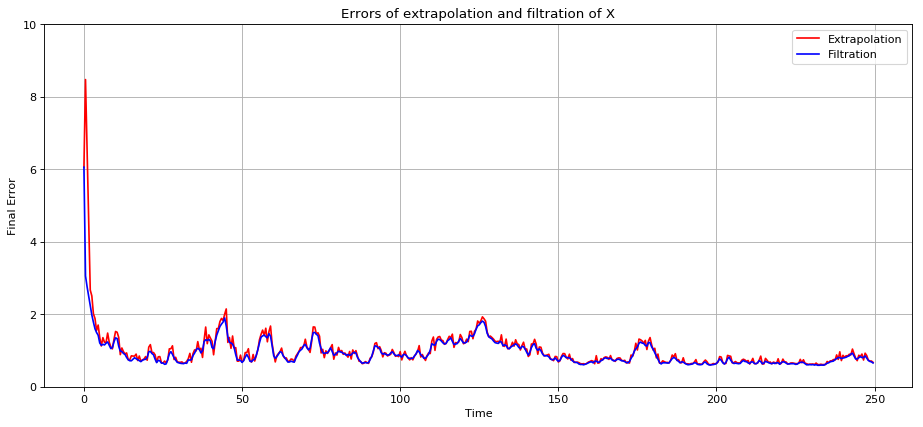

In [44]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Xp2, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Xf2, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of X')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,10)
plt.show()

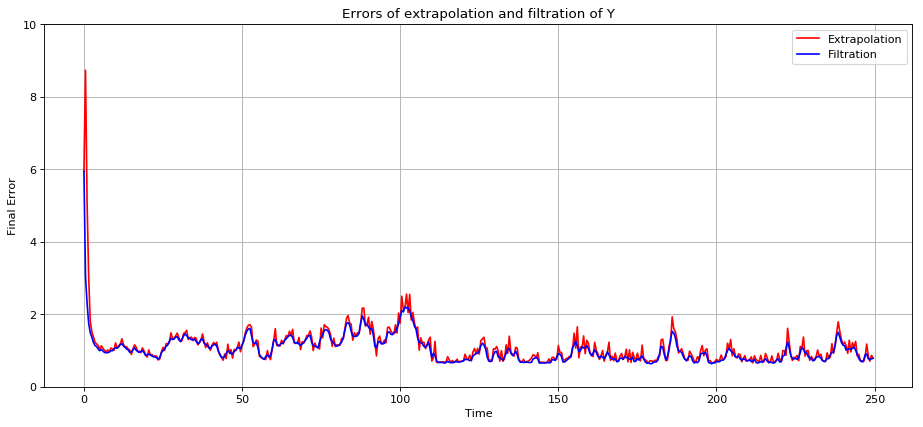

In [45]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, Final_Error_Yp2, 'r-', label = "Extrapolation")
plt.plot(time, Final_Error_Yf2, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of Y')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,10)
plt.show()

#### For estimation of coordinates extra data (odometry) improved the final error from 0.7-0.8 to 0.2-0.3 (approximately). This is a great improvemets in quality of trecking the vehicle.

## Conclusion
#### A tracking filter for estimating vehicle’s dynamic state by assimilating the navigation data coming from different sources was developed. GPS data (absolute positioning) and wheel odometry data (relative positioning) can be fused in Extended Kalman Filter to get accurate estimations. This can be used for intelligent traffic applications. Fused data can give much more accurate estimations. In this particular case, accurasy improved around 3-fold.